Introducción

La empresa OilyGiant busca identificar la mejor región para invertir en 200 nuevos pozos petrolíferos con un presupuesto de 100 millones de dólares. Para ello, se analizarán datos geológicos de tres regiones con el fin de predecir el volumen de reservas, estimar ganancias y evaluar riesgos.

El proyecto tiene como objetivos:

- Entrenar modelos de regresión lineal para predecir reservas.
- Seleccionar los 200 pozos más prometedores por región.
- Calcular beneficios potenciales y riesgos mediante bootstrapping.
- Recomendar la región más rentable y segura.

Las etapas incluyen preparación de datos, modelado, análisis de ganancias, evaluación de riesgos y selección final de la región óptima.

Inicialización y carga de datos

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [3]:
geo_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_2 = pd.read_csv('/datasets/geo_data_2.csv')

Observación de datos

In [4]:
geo_0.info()
geo_0.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [5]:
geo_1.info()
geo_1.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [6]:
geo_2.info()
geo_2.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Las tres bases de datos analizadas no presentan errores críticos, como valores faltantes, inconsistencias en los tipos de datos de las columnas u otras anomalías relevantes. A continuación, se detalla la descripción de las variables:

- id: Identificador único asignado a cada pozo de petróleo.
- f0, f1, f2: Conjunto de características numéricas asociadas a cada punto de estudio (su interpretación específica no es esencial, pero son relevantes para el modelado).
- product: Volumen estimado de reservas de petróleo en cada pozo, expresado en miles de barriles.

El objetivo principal del análisis es predecir el volumen de reservas (product) para identificar las ubicaciones con mayor potencial de extracción y, en función de ello, seleccionar las regiones óptimas para la inversión.

Análisis Exploratorio de Datos

En esta sección se realizará un análisis exploratorio para examinar las distribuciones de los datos, identificar posibles relaciones entre las variables y detectar valores atípicos (outliers) que puedan afectar el rendimiento del modelo predictivo.

Antes de profundizar en el análisis, es importante retomar ciertos valores clave definidos previamente para establecer referencias y facilitar la interpretación de los resultados:

- El presupuesto asignado para el desarrollo de 200 pozos petroleros es de 100 millones de dólares.

- Cada barril de petróleo genera 4.5 USD de ingresos, lo que equivale a 4,500 USD por cada unidad de producto, dado que la columna product expresa el volumen en miles de barriles.

- El costo promedio de desarrollo de un pozo petrolero es:

    100,000,000 USD

    __________________  = 500,000 USD/pozo

          200

- Para que un pozo sea rentable, el ingreso que genere debe superar este costo. Si dividimos el costo por pozo entre el ingreso por unidad de producto:

    500,000

    __________  ≈ 111.11

     4,500

Esto significa que un pozo debe producir más de 111.11 unidades de producto (aproximadamente 111 mil barriles) para considerarse rentable.

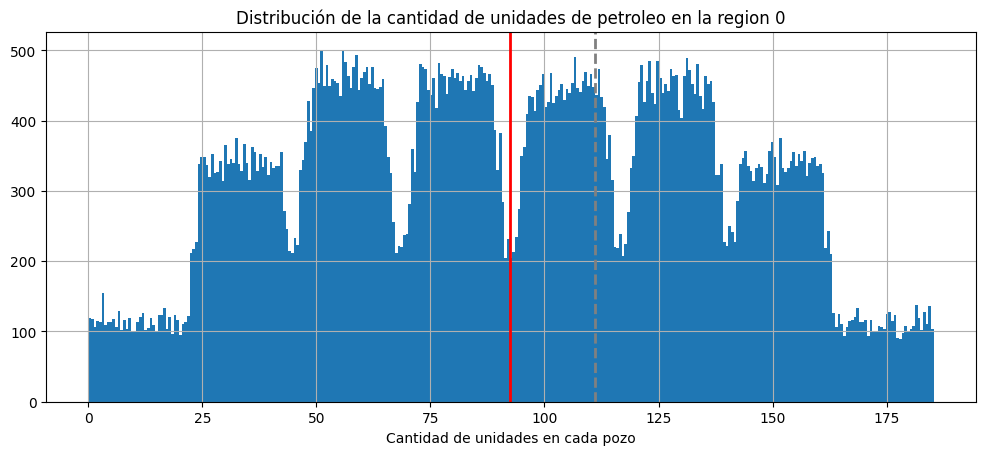

Promedio: 92.500


In [7]:
fig, ax = plt.subplots(figsize=(12,4.8))

bins = int(np.ceil(np.sqrt(100000)))

geo_0['product'].hist(bins = bins)

plt.axvline(x=111.11, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=geo_0['product'].mean(), color='red', linewidth=2)

ax.set_xlabel('Cantidad de unidades en cada pozo')
ax.set_title('Distribución de la cantidad de unidades de petroleo en la region 0')

plt.show()

print(f'Promedio: {geo_0["product"].mean():.3f}')

In [8]:
geo_0[geo_0['product'] > 111.11].shape[0]

36584

La distribución observada resulta bastante particular. Se identifican cuatro picos principales bien definidos, separados por intervalos con menor densidad de valores, así como dos picos secundarios en los extremos cercanos a dichos grupos principales. Además, se aprecia una ligera concentración de valores en los extremos, aunque destaca el corte abrupto en el extremo derecho, lo que sugiere la posibilidad de que los datos hayan sido previamente depurados para eliminar valores atípicos.

Por otro lado, únicamente 36,584 pozos (equivalente al 36.58% del total) superan el umbral de 111.11 unidades de producto, cifra mínima estimada para cubrir los costos de construcción y generar ganancias.

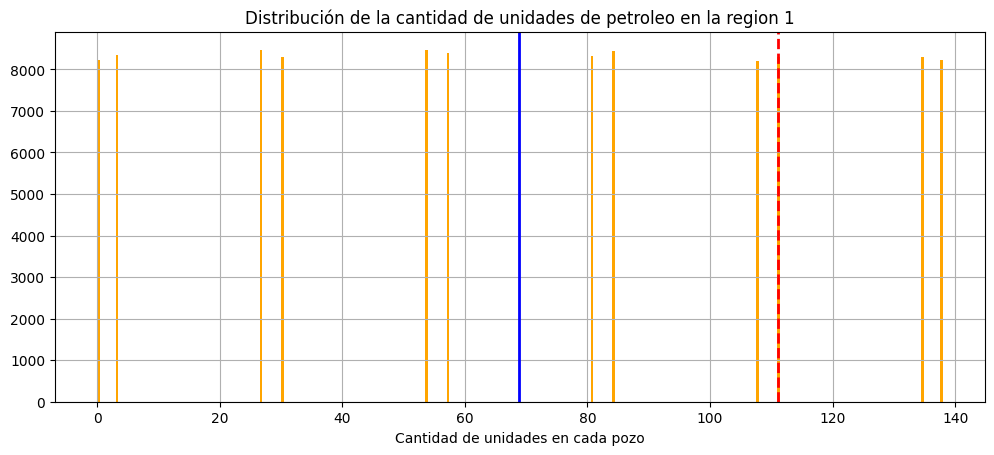

Promedio: 68.825


In [9]:
fig, ax = plt.subplots(figsize=(12,4.8))

bins = int(np.ceil(np.sqrt(100000)))

geo_1['product'].hist(bins = bins, color='orange')

plt.axvline(x=111.11, color='red', linestyle='--', linewidth=2)
plt.axvline(x=geo_1['product'].mean(), color='blue', linewidth=2)

ax.set_xlabel('Cantidad de unidades en cada pozo')
ax.set_title('Distribución de la cantidad de unidades de petroleo en la region 1')

plt.show()

print(f'Promedio: {geo_1["product"].mean():.3f}')


<div class="alert alert-block alert-danger">

<b>Comentario del revisor</b> <a class="tocSkip"></a><br>

<b>A resolver</b> ❗ - Buen intento al crear un histograma para visualizar la distribución de la variable `product`. Sin embargo, hay un error importante en la forma de definir los `bins`.

Estás usando la fórmula `bins = int(np.ceil(np.sqrt(100000)))`, que calcula los bins sobre el número **100,000**, sin relación con el tamaño real de tu conjunto de datos (`geo_1`). Esto podría distorsionar gravemente la visualización. En lugar de eso, deberías calcular los `bins` con base en el tamaño real del DataFrame, así:

```python
bins = int(np.ceil(np.sqrt(len(geo_1))))
```


</div



Este resultado es aún más llamativo. La distribución sugiere posibles problemas en la carga o generación de los datos, ya que los valores se encuentran concentrados en puntos muy específicos, lo cual no parece reflejar una variabilidad realista.

A pesar de esta particularidad, se observa que aproximadamente 16,000 pozos superan el umbral de rentabilidad previamente establecido.

In [10]:
geo_1['product'].value_counts()

53.906522     8472
26.953261     8468
84.038886     8431
57.085625     8390
3.179103      8337
80.859783     8320
30.132364     8306
134.766305    8304
110.992147    8303
0.000000      8235
137.945408    8233
107.813044    8201
Name: product, dtype: int64

Se confirma que los valores de esta región están limitados a únicamente 12 valores discretos y específicos, incluyendo algunos registros con un valor de 0.0. Esta característica es claramente visible en la tabla, aunque puede pasar desapercibida a simple vista debido a la cantidad de datos repetidos.

Dado que solo contamos con información de tres regiones, descartar esta región implicaría perder aproximadamente un 33% de los datos, lo que no resulta conveniente. Por lo tanto, se continuará el análisis con la información disponible, aunque una revisión preliminar sugiere que la Región 1 probablemente no será la más favorable para el desarrollo de pozos.

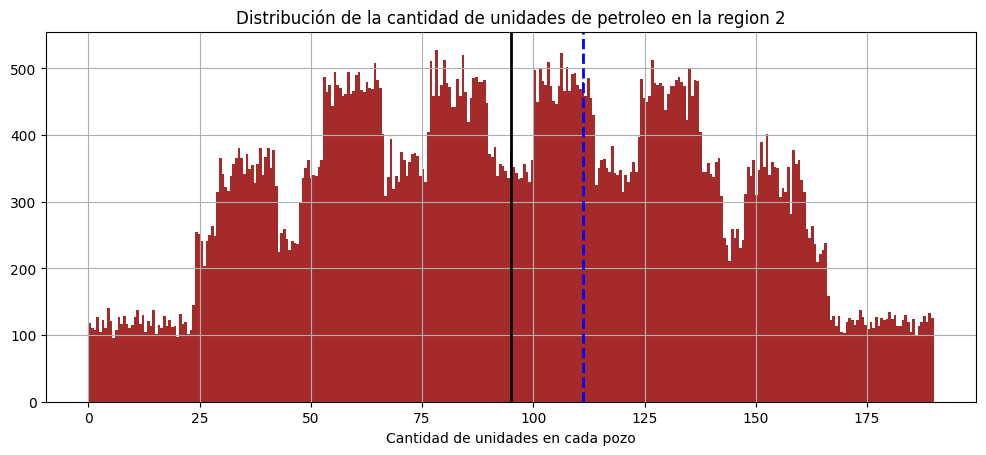

Promedio: 95.000


In [11]:
fig, ax = plt.subplots(figsize=(12,4.8))

bins = int(np.ceil(np.sqrt(100000)))

geo_2['product'].hist(bins = bins, color='brown')

plt.axvline(x=111.11, color='blue', linestyle='--', linewidth=2)
plt.axvline(x=geo_2['product'].mean(), color='black', linewidth=2)

ax.set_xlabel('Cantidad de unidades en cada pozo')
ax.set_title('Distribución de la cantidad de unidades de petroleo en la region 2')

plt.show()

print(f'Promedio: {geo_2["product"].mean():.3f}')

Al analizar los datos, se observa que la distribución de geo_0 y geo_1 es bastante similar, aunque la media de geo_1 está más cercana al punto de quiebre. A primera vista, esta región podría parecer más prometedora; sin embargo, dado que ninguna de las regiones presenta una media superior al punto de quiebre, no se puede sacar conclusiones definitivas por el momento.

Resultados del EDA:
Aunque el análisis exploratorio fue superficial, nos permitió extraer dos hallazgos importantes:

No se puede utilizar la tabla geo_1 debido a problemas que afectaron la calidad de sus datos. Afortunadamente, se cuenta con al menos dos tablas viables para trabajar.

Ninguna región muestra rentabilidad evidente en esta etapa, ya que los promedios de ambas tablas se encuentran por debajo del punto de quiebre.

Entrenamiento y prueba del modelo de Regresión Lineal

Segmentación de datos

In [13]:
features_0 = geo_0[['f0', 'f1', 'f2']]
target_0 = geo_0['product']

features_1 = geo_1[['f0', 'f1', 'f2']]
target_1 = geo_1['product']

features_2 = geo_2[['f0', 'f1', 'f2']]
target_2 = geo_2['product']

Como se muestra, no se guardará las columnas ID ya que no será validada para este modelo.

In [14]:
features_0_train, features_0_valid, target_0_train, target_0_valid = train_test_split(
    features_0, target_0, test_size= 0.25, random_state= 85964)

features_1_train, features_1_valid, target_1_train, target_1_valid = train_test_split(
    features_1, target_1, test_size= 0.25, random_state= 85964)

features_2_train, features_2_valid, target_2_train, target_2_valid = train_test_split(
    features_2, target_2, test_size= 0.25, random_state= 85964)

Entrenamiento de los modelos

Tomando en cuenta para cada conjunto de datos; al tratar de una función matemática, la regresión linela no cuenta con una gran cantidad de hiperparámentros que puedan ajustarse.

In [15]:
model_geo_0 = LinearRegression()

In [16]:
model_geo_0.fit(features_0_train, target_0_train)

LinearRegression()

In [18]:
predictions_0 = pd.concat(
    [target_0_valid.reset_index(drop= True), pd.Series(model_geo_0.predict(features_0_valid))], axis= 1
)

In [19]:
predictions_0 = predictions_0.rename(columns= {
    'product': 'real_value',
    0:'prediction'
})

In [17]:
predictions_0

,real_value,prediction
0,68.077172,43.932379
1,59.431029,115.670378
2,167.877901,102.373501
3,134.965417,79.732264
4,148.136790,99.487249
...,...,...
24995,146.157947,90.255225
24996,40.851577,64.683172
24997,13.229072,92.008923
24998,100.788405,101.440027


In [20]:
print(f'''
Volumen promedio de reservas previstas: {predictions_0['prediction'].mean():.4f} \n
RECM del modelo: {mean_squared_error(predictions_0['real_value'],predictions_0['prediction'])**0.5:.4f}
''')


Volumen promedio de reservas previstas: 92.5367 

RECM del modelo: 37.7451



In [21]:
model_geo_1 = LinearRegression()

In [22]:
model_geo_1.fit(features_1_train, target_1_train)

LinearRegression()

In [23]:
predictions_1 = pd.concat(
    [target_1_valid.reset_index(drop= True), pd.Series(model_geo_1.predict(features_1_valid))], axis= 1
)

In [24]:
predictions_1 = predictions_1.rename(columns= {
    'product': 'real_value',
    0:'prediction'
})

In [23]:
predictions_1

,real_value,prediction
0,84.038886,83.750162
1,134.766305,135.364841
2,134.766305,136.093130
3,134.766305,135.827082
4,107.813044,108.197564
...,...,...
24995,110.992147,110.622635
24996,0.000000,1.255047
24997,107.813044,108.857192
24998,3.179103,2.924738


In [25]:
print(f'''
Volumen promedio de reservas previstas: {predictions_1['prediction'].mean():.4f} \n
RECM del modelo: {mean_squared_error(predictions_1['real_value'],predictions_1['prediction'])**0.5:.4f}
''')


Volumen promedio de reservas previstas: 68.9255 

RECM del modelo: 0.8884



In [26]:
model_geo_2 = LinearRegression()

In [27]:
model_geo_2.fit(features_2_train, target_2_train)

LinearRegression()

In [28]:
predictions_2 = pd.concat(
    [target_2_valid.reset_index(drop= True), pd.Series(model_geo_2.predict(features_2_valid))], axis= 1
)

In [31]:
predictions_2 = predictions_2.rename(columns= {
    'product': 'real_value',
    0:'prediction'
})

In [30]:
predictions_2

,real_value,prediction
0,125.720167,101.711068
1,85.483887,78.034615
2,91.337368,69.241097
3,66.343315,87.525741
4,46.225876,89.832948
...,...,...
24995,93.229843,72.145886
24996,54.510304,81.029650
24997,113.840910,96.921233
24998,134.151028,106.616293


In [32]:
print(f'''
Volumen promedio de reservas previstas: {predictions_2['prediction'].mean():.4f} \n
RECM del modelo: {mean_squared_error(predictions_2['real_value'],predictions_2['prediction'])**0.5:.4f}
''')


Volumen promedio de reservas previstas: 95.0731 

RECM del modelo: 40.0505



Recapitulación de los modelos:
- Modelo geo_0
  - Volumen promedio de las predicciones: 92.53
  - RECM del modelo: 37.74
- Modelo geo_1
  - Volumen promedio de las predicciones: 68.92
  - RECM del modelo: 0.88
- Modelo geo_2
  - Volumen promedio de las predicciones: 95.07
  - RECM del modelo: 40.05

Al analizar estos resultados, se observa que:
- La región 0 presenta un promedio y un RECM relativamente bajos, con el promedio aproximadamente 2.45 veces el RECM.
- La región 2 tiene un volumen promedio mayor y un RECM también más alto, con el promedio siendo aproximadamente 2.37 veces el RECM.

Utilizado la proporción del RECM respecto al promedio para obtener una medida adimensional que indique la variabilidad relativa de cada modelo.

Con respecto a la región 1 no se tomó en cuenta por:
- Los datos presentan características muy peculiares.
- Los valores de volumen y RECM son significativamente menores que los de las otras regiones, aunque su RECM es extremadamente bajo, el hecho de que esté casi dos veces por debajo del punto de equilibrio indica que será dificil encontrar oportunidades rentables en esta región.

Cálculo de ganancias

Contando con un valor clave de 111.11 unidades, que representa el umbral a partir del cual un pozo se considera rentable. Es decir, si un pozo tiene más unidades que este valor, cubrirá los gastos de construcción y empezará a generar ganancias.

Creando una función que calcule el beneficio para cada predicción en cada región. Antes, recordando los valores clave para este cálculo:
- El presupuesto total para desarrollar 200 pozos petroleros es de 100 millones de dólares.
- El costo de construcción de un pozo petrolero es de 500,000 USD.
- Cada barril de materia prima genera 4.5 USD de ingresos. Como el volumen de reservas está expresado en miles de barriles, el ingreso por unidad de producto es de 4,500 USD.

A esto, se deduce que un pozo necesita 111.11 unidades para cubrir sus costos; cualquier valor superior representa ganancia potencial.

In [36]:
def get_real_income(table, top):
    top_predict = table.sort_values(by= 'prediction', ascending= False)[:top].index
    real_benefits = table.iloc[top_predict]['real_value']*4500 - 500000
    return real_benefits.sum()

In [37]:
get_real_income(predictions_0, 200)

29431667.72985544

In [38]:
predictions_0['benefit'] = get_real_income(predictions_0,200)

predictions_1['benefit'] = get_real_income(predictions_1,200)

predictions_2['benefit'] = get_real_income(predictions_2,200)

In [39]:
top_predictions_0 = predictions_0.dropna().sort_values(by='prediction', ascending= False)
top_predictions_1 = predictions_1.dropna().sort_values(by='prediction', ascending= False)
top_predictions_2 = predictions_2.dropna().sort_values(by='prediction', ascending= False)

In [41]:
print(
f'''Volumen de petroleo total de las 200 mejores predicciones:
Region 0: {top_predictions_0['prediction'].sum():.4f}
Region 1: {top_predictions_1['prediction'].sum():.4f}
Region 2: {top_predictions_2['prediction'].sum():.4f}
''')

Volumen de petroleo total de las 200 mejores predicciones:
Region 0: 2313418.6179
Region 1: 1723137.7333
Region 2: 2376827.9632



In [42]:
for region in [top_predictions_0,top_predictions_1,top_predictions_2]:
    print(region['prediction'].min())

11.887545476064432
-2.0654509239881467
13.814826422017788


Al analizar los resultados, observando que únicamente la región 1 presenta pozos cuyo volumen no alcanza el punto de quiebre. Por el contrario, las regiones 0 y 2 muestran buenos volúmenes; los 200 mejores pozos en estas regiones generan ganancias mínimas garantizadas.

In [44]:
print(
f'''Ganancia total de las 200 mejores predicciones:
Region 0: U$ {top_predictions_0['benefit'].sum():.2f}
Region 1: U$ {top_predictions_1['benefit'].sum():.2f}
Region 2: U$ {top_predictions_2['benefit'].sum():.2f}
''')

Ganancia total de las 200 mejores predicciones:
Region 0: U$ 735791693246.39
Region 1: U$ 603771674170.38
Region 2: U$ 618968418957.59



In [45]:
print(
f'''Ganancia promedio de las 200 mejores predicciones:
Region 0: U$ {top_predictions_0['benefit'].mean():.2f}
Region 1: U$ {top_predictions_1['benefit'].mean():.2f}
Region 2: U$ {top_predictions_2['benefit'].mean():.2f}
''')

Ganancia promedio de las 200 mejores predicciones:
Region 0: U$ 29431667.73
Region 1: U$ 24150866.97
Region 2: U$ 24758736.76



Tras analizar los datos, considerando la región 0 al presentar la mayor ganancia total y su promedio de beneficios por pozo también su superior al de los demás regiones.

Estos factores aseguran no solo una mayor ganancia final tras la extracción de los recursos, sino también su beneficio constante durante todo el proceso, ya que cada pozo genera, en promedio; más ingresos que los de otras regiones. Esto brinda mayor seguridad ante posibles problemas operativos o factores externos.

Se puede recomendar la región 2, que se ubicó consistentemente en el segundo lugar según las métricas obtenidas de las predicciones.

El análisis de riesgo posterior será clave para determinar finalmente la región óptima.

Cálculo de riesgos

Ahora nos enfocaremos en cuantificar el riesgo de pérdidas en cada región. Para ello, utilizaremos bootstrapping, una técnica que, aunque a veces pueda parecer “tramposa”, está respaldada por uno de los teoremas más sólidos de las matemáticas.

Para simplificar el desarrollo y hacer que los cálculos sean más robustos, aprovecharemos la biblioteca SciPy y su función de bootstrapping, lo que nos permitirá optimizar el código y obtener resultados más confiables.

In [46]:
def bootstrap(data, n_iterations):
    
    benefits = []
    
    for k in range(n_iterations):
        
        subsample = data.sample(n=500, replace=True).reset_index()
        variable = get_real_income(subsample, 200)
        benefits.append(variable)
        
    return pd.Series(benefits)

In [47]:
sample_0 = bootstrap(predictions_0, 1000)

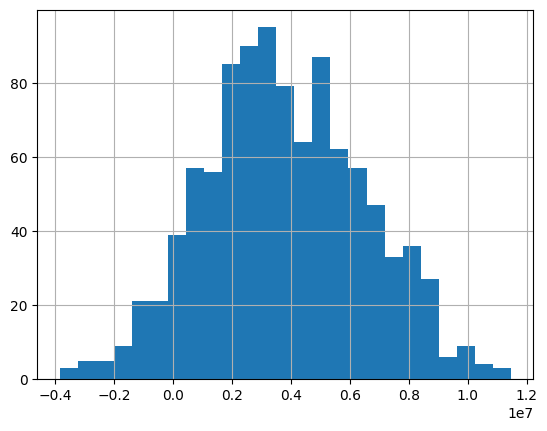

<Figure size 1200x700 with 0 Axes>

In [48]:
sample_0.hist(bins=25)
plt.figure(figsize=(12,7))
plt.show()

In [50]:
sample_0.mean()

3796086.7687838925

In [51]:
print(f'Intervalo de confianza: U$({sample_0.quantile(0.025)},{sample_0.quantile(0.975)})')

Intervalo de confianza: U$(-1154158.3706614545,8880312.665500646)


Se ha obtenido un intervalo de confianza del 95% que va desde -1,317,952 USD hasta 8,695,669 USD, con un valor medio estimado de 3,893,728 USD.

Este resultado evidencia que no todos los pozos predichos generan ganancias positivas. Por ello, el siguiente paso es determinar cuál es el riesgo de pérdida en la región 0.

In [52]:
(sample_0<0).mean()*100

7.7

In [53]:
sample_1 = bootstrap(predictions_1, 1000)

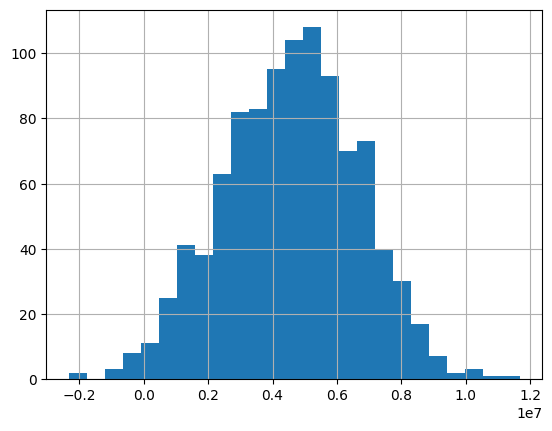

<Figure size 1200x700 with 0 Axes>

In [54]:
sample_1.hist(bins=25)
plt.figure(figsize=(12,7))
plt.show()

In [55]:
sample_1.mean()

4586369.728340092

In [56]:
print(f'Intervalo de confianza: U$({sample_1.quantile(0.025)},{sample_1.quantile(0.975)})')

Intervalo de confianza: U$(523389.5472348265,8615214.641012799)


Para la región 1, obtuvimos un intervalo de confianza de (629,844 USD, 8,809,107 USD), con un promedio estimado de 4,658,838 USD.

Esto indica que no se observan pérdidas dentro del intervalo de confianza, aunque es importante calcular la probabilidad exacta de pérdidas, que en este caso sería inferior al 5%.

In [58]:
(sample_1<0).mean()*100

1.5

In [61]:
sample_2 = bootstrap(predictions_2, 1000)

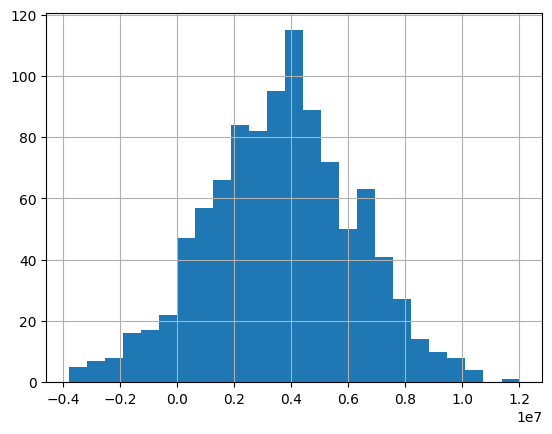

<Figure size 1200x700 with 0 Axes>

In [60]:
sample_2.hist(bins=25)
plt.figure(figsize=(12,7))
plt.show()

In [62]:
sample_2.mean()

3697523.106910907

In [63]:
print(f'Intervalo de confianza: U$({sample_2.quantile(0.025)},{sample_2.quantile(0.975)})')

Intervalo de confianza: U$(-1486380.8374284464,8840978.728254922)


Para la región 2, el intervalo de confianza se encuentra en el rango (-1,893,801 USD, 8,862,464 USD), con una media estimada de 3,580,360 USD.

Esta región presenta el intervalo de confianza más amplio y la media más baja de las tres, lo que sugiere que es la región con mayor riesgo según este análisis.

In [64]:
(sample_2<0).mean()*100

8.7

Conclusión:

Tras el análisis de bootstrapping, los resultados muestran que la región 1 parece la más prometedora: presenta el promedio de ganancias más alto, su intervalo de confianza no incluye pérdidas y tiene el menor riesgo de pérdida, cercano al 1.4%.

Sin embargo, estos hallazgos contrastan con las conclusiones obtenidas en etapas previas, donde la región 0 había sido considerada la más rentable y la región 1 se ubicaba en último lugar según nuestras métricas iniciales.

Este cambio de perspectiva puede explicarse por las características anómalas de los datos de la región 1. En el EDA se detectó que el conjunto presentaba picos concentrados en valores muy específicos, lo que sugiere una distribución poco natural. Es probable que, al seleccionar los 200 mejores pozos, estos valores hayan sesgado el resultado, generando métricas que no reflejan de manera fiel el potencial real de la región. La baja varianza de estos datos probablemente influyó en que el bootstrapping arrojara estimaciones muy concentradas alrededor de dichos valores.

Por esta razón, la recomendación final es optar por la región 0. Aunque el análisis estadístico favorece a la región 1, no es prudente basar la decisión en datos cuya distribución evidencia posibles problemas en el pipeline de adquisición o procesamiento.

Se sugiere:

Auditar y depurar los datos de la región 1 para identificar las causas de sus anomalías.

Repetir el análisis con los datos corregidos, con el fin de confirmar las conclusiones y reforzar la decisión final.